In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from statsmodels.formula.api import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import levene
from statsmodels.stats.diagnostic import het_breuschpagan
pd.options.mode.chained_assignment = None

In [3]:
df = pd.read_csv('C:\\Users\\tilleymusprime\\Desktop\\mcclean1.csv')

In [4]:
#In this workbook, we will be looking at the Right Guard position
rg = df[df['Position'] == 'RG']

In [5]:
#The firs tthing we will do is identify the significant correlations in with overall rating
rgcorr = rg.corr()

In [6]:
rgpos = rgcorr[rgcorr['Overall Rating'] >= 0.5]

In [7]:
rgneg = rgcorr[rgcorr['Overall Rating'] <= -0.5]

In [8]:
print(rgpos['Overall Rating'], rgneg['Overall Rating'])
#These are all of the significant correlations.  We will start with Vif testing to make sure there is no multicollinearity

Awareness          0.894857
Impact Blocking    0.610138
Overall Rating     1.000000
Pass Block         0.760143
Run Block          0.523268
Strength           0.566848
Name: Overall Rating, dtype: float64 Series([], Name: Overall Rating, dtype: float64)


In [9]:
rgsig = rg[['Awareness', 'Impact Blocking', 'Pass Block', 'Run Block', 'Strength']]
X = add_constant(rgsig)
pd.Series([variance_inflation_factor(X.values, i)
          for i in range(X.shape[1])],
         index=X.columns)
#It looks like all of our VIF scores are below 5 so we can move on to statistical testing

const              669.157120
Awareness            1.853326
Impact Blocking      1.424894
Pass Block           1.503846
Run Block            1.211624
Strength             1.359118
dtype: float64

In [10]:
RG = sm.OLS(rg['Overall Rating'], rgsig).fit()
print(RG.summary())
#It looks like all of our variables are significant

                            OLS Regression Results                            
Dep. Variable:         Overall Rating   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.337e+04
Date:                Sat, 21 Jul 2018   Prob (F-statistic):          1.98e-185
Time:                        00:59:05   Log-Likelihood:                -256.94
No. Observations:                 124   AIC:                             523.9
Df Residuals:                     119   BIC:                             538.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Awareness           0.3832      0.015     

In [11]:
def model():
    pv = 0.3832*rg['Awareness']+ 0.1057*rg['Impact Blocking']+ 0.3457*rg['Pass Block']+ 0.2180*rg['Run Block'] - 0.0776*rg['Strength']
    return pv

In [12]:
rg['Predicted Value'] = model()
rg['Residual'] = rg['Predicted Value'] - rg['Overall Rating']

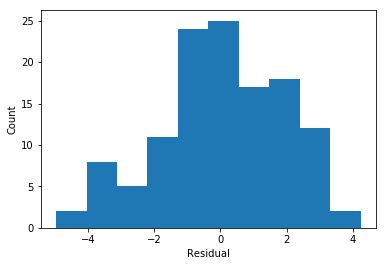

In [13]:
plt.hist(rg['Residual'])
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

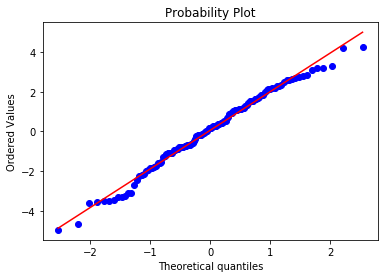

In [14]:
stats.probplot(rg['Residual'], plot=plt)
plt.show()
#There does not appear to be any outliers in the residuals

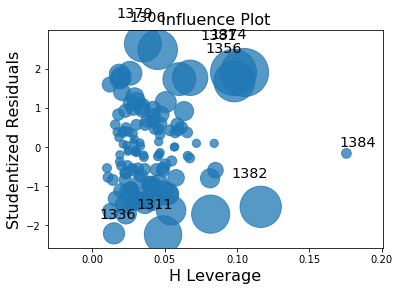

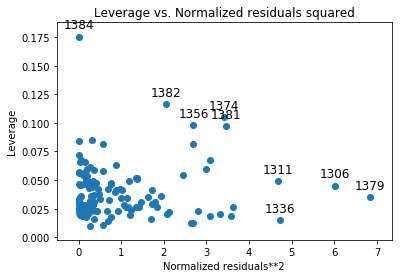

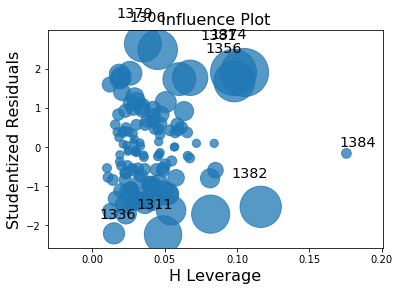

In [15]:
from statsmodels.graphics.regressionplots import *
plot_leverage_resid2(RG)
influence_plot(RG)
#There are some high leverage points and some high residuals but no data points that are both

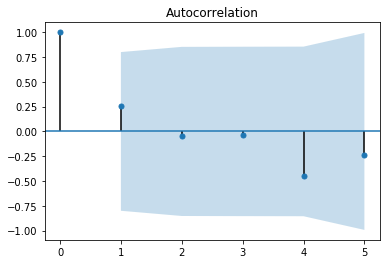

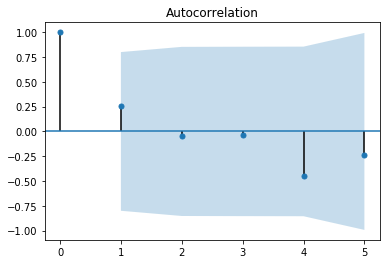

In [19]:
rgcorr1 = rg[['Overall Rating','Awareness', 'Impact Blocking', 'Pass Block', 'Run Block', 'Strength']].corr()
plot_acf(rgcorr1['Overall Rating'])
#there does not appear to be any autocorrelation looking at the plot below
#There is also a Durbin-Watson correlation of 1.816, which indicates no significant autocoreelation

In [20]:
#Finally, we check for heterokedasticity
het_breuschpagan(rg['Residual'], rgsig)
#Due to the low p-values, we can reject the null that there is homoskedasticity in the data

(52.6453608071738,
 1.0109471539952054e-10,
 17.559609317409393,
 5.347139233168985e-13)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(rgsig, rg['Overall Rating'], test_size = 0.3, random_state =42)
reg=LinearRegression()
reg.fit(X_train, y_train)
rgcv = cross_val_score(reg, rgsig, rg['Overall Rating'], cv=5)
rgcv_mean = np.mean(rgcv)
print(rgcv, rgcv_mean)
#it looks like the model did a good job of explaining the variation in the data

[0.98749449 0.98600925 0.99000867 0.97392174 0.88472005] 0.9644308396809123


In [23]:
rgdesc = rg[['Overall Rating','Awareness', 'Impact Blocking', 'Pass Block', 'Run Block', 'Strength', 'Predicted Value', 'Residual']]
rgdesc1 = rgdesc.describe()
rgdesc1.to_csv('C:\\Users\\tilleymusprime\\Desktop\\rgdesc1.csv')